In [1]:
# add necessary toolbox

import os
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms

In [2]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print('using gpu: %s' % torch.cuda.is_available())

using gpu: False


In [3]:
root_dir = './data/'

if not os.path.exists(root_dir):
    os.mkdir(root_dir)

train_loader = torch.utils.data.DataLoader(
    datasets.MNIST(root_dir, train=True, download=True, transform = transforms.ToTensor()), 
    batch_size=256, shuffle = True
)

test_loader = torch.utils.data.DataLoader(
    datasets.MNIST(root_dir, train=False, download=True, transform = transforms.ToTensor()),
    batch_size=10, shuffle = False
)

In [4]:
# helper functions

def to_img(x):
    x = x.cpu().data.numpy()
    x = 0.5*(x+1)
    x = np.clip(x,0,1)
    x = x.reshape([-1, 28, 28])
    return x

def plot_reconstructions(model):
    # encode then decode
    data, _ = next(iter(test_loader))
    data = data.view([-1, 784])
    data.requires_grad = False
    data = data.to(device)
    true_imgs = data
    encoded_imgs = model.encoder(data)
    decoded_imgs = model.decoder(encoded_imgs)
    
    true_imgs = to_img(true_imgs)
    decoded_imgs = to_img(decoded_imgs)
    encoded_imgs = encoded_imgs.cpu().data.numpy()
    
    n = 10
    plt.figure(figsize=(20, 4))
    for i in range(n):
        # display original
        ax = plt.subplot(3, n, i + 1)
        plt.imshow(true_imgs[i])
        plt.gray()
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)
        
        ax = plt.subplot(3, n, i + 1 + n)
        plt.imshow(encoded_imgs[i].reshape(-1,4))
        plt.gray()
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)

        # display reconstruction
        ax = plt.subplot(3, n, i + 1 + n + n)
        plt.imshow(decoded_imgs[i])
        plt.gray()
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)
    
    plt.show()    

In [5]:
# simple autoencoder

class AutoEncoder(nn.Module):
    def __init__(self, input_dim, encoding_dim):
        super(AutoEncoder, self).__init__()
        self.encoder = nn.Linear(input_dim, encoding_dim)
        self.decoder = nn.Linear(encoding_dim, input_dim)
    def forward(self, x):
        encoded = F.relu(self.encoder(x))
        decoded = self.decoder(encoded)
        return decoded

In [6]:
input_dim = 784
encoding_dim = 64

model = AutoEncoder(input_dim, encoding_dim)
model = model.to(device)
optimizer = optim.Adam(model.parameters())
loss_fn = torch.nn.MSELoss()

In [7]:
def train_model(model, loss_fn, data_loader=None, epochs=1, optimizer=None):
    model.train()
    for epoch in range(epochs):
        for batch_idx, (data,_) in enumerate(train_loader):
            data = data.view([-1, 784]).to(device)
            optimizer.zero_grad()
            output = model(data)
            loss = loss_fn(output, data)
            loss.backward()
            optimizer.step()
            if batch_idx % 100 == 0:
                print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, batch_idx * len(data), len(data_loader.dataset),
                100. * batch_idx / len(data_loader), loss.data.item()
                ))

In [8]:
train_model(model, loss_fn, data_loader=train_loader, epochs=10, optimizer=optimizer)

Train Epoch: 0 [0/60000 (0%)]	Loss: 0.131079
Train Epoch: 0 [25600/60000 (43%)]	Loss: 0.043966
Train Epoch: 0 [51200/60000 (85%)]	Loss: 0.032184
Train Epoch: 1 [0/60000 (0%)]	Loss: 0.028709
Train Epoch: 1 [25600/60000 (43%)]	Loss: 0.024518
Train Epoch: 1 [51200/60000 (85%)]	Loss: 0.021265
Train Epoch: 2 [0/60000 (0%)]	Loss: 0.020128
Train Epoch: 2 [25600/60000 (43%)]	Loss: 0.017776
Train Epoch: 2 [51200/60000 (85%)]	Loss: 0.017145
Train Epoch: 3 [0/60000 (0%)]	Loss: 0.017691
Train Epoch: 3 [25600/60000 (43%)]	Loss: 0.017166
Train Epoch: 3 [51200/60000 (85%)]	Loss: 0.017094
Train Epoch: 4 [0/60000 (0%)]	Loss: 0.016348
Train Epoch: 4 [25600/60000 (43%)]	Loss: 0.016855
Train Epoch: 4 [51200/60000 (85%)]	Loss: 0.016166
Train Epoch: 5 [0/60000 (0%)]	Loss: 0.015777
Train Epoch: 5 [25600/60000 (43%)]	Loss: 0.015611
Train Epoch: 5 [51200/60000 (85%)]	Loss: 0.015215
Train Epoch: 6 [0/60000 (0%)]	Loss: 0.015302
Train Epoch: 6 [25600/60000 (43%)]	Loss: 0.015309
Train Epoch: 6 [51200/60000 (85%)]	

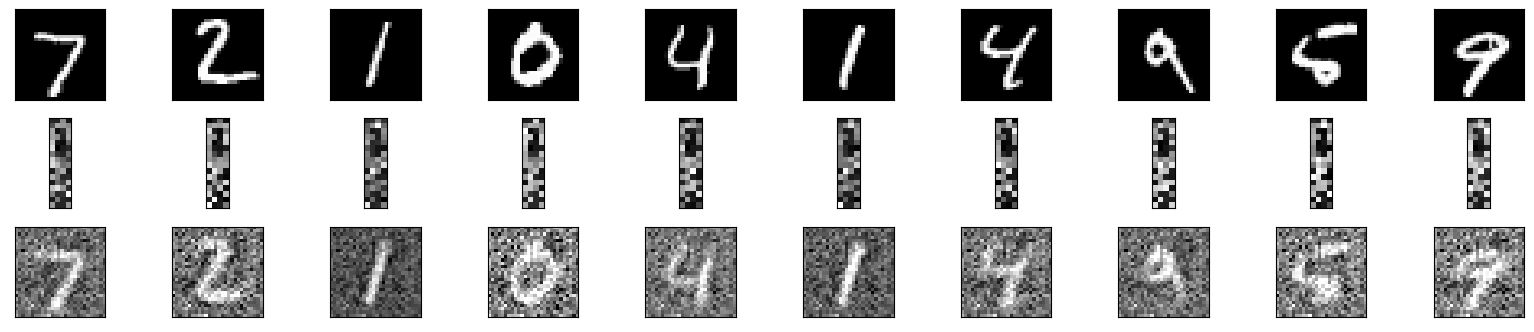

In [9]:
plot_reconstructions(model)

In [10]:
hidden_dim_1 = 128
hidden_dim_2 = 64

class DeepAutoEncoder(nn.Module):
    def __init__(self, input_dim, encoding_dim):
        super(DeepAutoEncoder, self).__init__()
        self.encoder = nn.Sequential(
            nn.Linear(input_dim, hidden_dim_1),
            nn.ReLU(),
            nn.Linear(hidden_dim_1, hidden_dim_2),
            nn.ReLU(),            
            nn.Linear(hidden_dim_2, encoding_dim),
        )
        self.decoder = nn.Sequential(
            nn.Linear(encoding_dim, hidden_dim_2),
            nn.ReLU(),
            nn.Linear(hidden_dim_2, hidden_dim_1),
            nn.ReLU(),
            nn.Linear(hidden_dim_1, input_dim),
            nn.Sigmoid()
        )
        
    def forward(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return decoded

In [11]:
input_dim = 784
encoding_dim = 32

model = DeepAutoEncoder(input_dim, encoding_dim)
model = model.to(device)
optimizer = optim.Adam(model.parameters())
loss_fn = torch.nn.MSELoss()

In [12]:
train_model(model, loss_fn, data_loader=train_loader,epochs=10,optimizer=optimizer)

Train Epoch: 0 [0/60000 (0%)]	Loss: 0.230695
Train Epoch: 0 [25600/60000 (43%)]	Loss: 0.070846
Train Epoch: 0 [51200/60000 (85%)]	Loss: 0.058590
Train Epoch: 1 [0/60000 (0%)]	Loss: 0.052926
Train Epoch: 1 [25600/60000 (43%)]	Loss: 0.043212
Train Epoch: 1 [51200/60000 (85%)]	Loss: 0.038387
Train Epoch: 2 [0/60000 (0%)]	Loss: 0.033907
Train Epoch: 2 [25600/60000 (43%)]	Loss: 0.031766
Train Epoch: 2 [51200/60000 (85%)]	Loss: 0.029539
Train Epoch: 3 [0/60000 (0%)]	Loss: 0.029367
Train Epoch: 3 [25600/60000 (43%)]	Loss: 0.026154
Train Epoch: 3 [51200/60000 (85%)]	Loss: 0.028334
Train Epoch: 4 [0/60000 (0%)]	Loss: 0.024752
Train Epoch: 4 [25600/60000 (43%)]	Loss: 0.024119
Train Epoch: 4 [51200/60000 (85%)]	Loss: 0.022411
Train Epoch: 5 [0/60000 (0%)]	Loss: 0.023028
Train Epoch: 5 [25600/60000 (43%)]	Loss: 0.022570
Train Epoch: 5 [51200/60000 (85%)]	Loss: 0.021094
Train Epoch: 6 [0/60000 (0%)]	Loss: 0.021865
Train Epoch: 6 [25600/60000 (43%)]	Loss: 0.020216
Train Epoch: 6 [51200/60000 (85%)]	

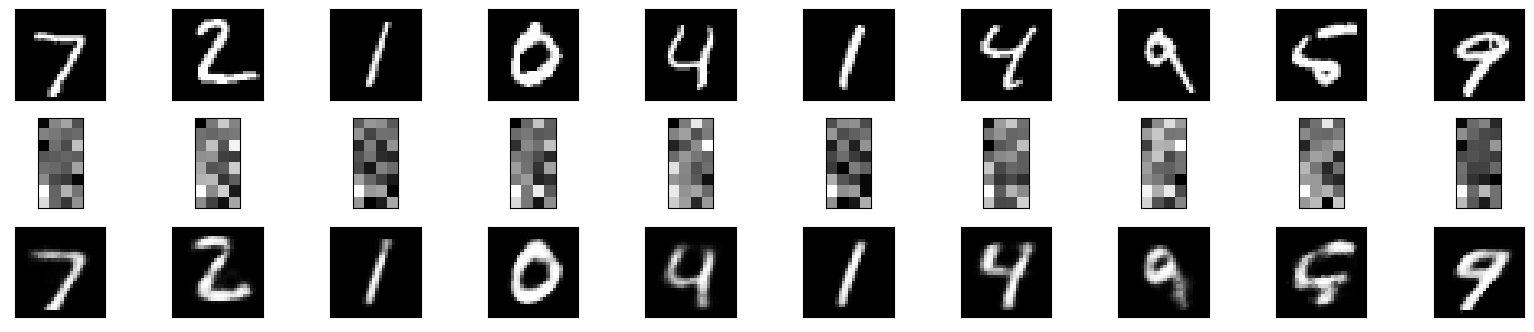

In [13]:
plot_reconstructions(model)

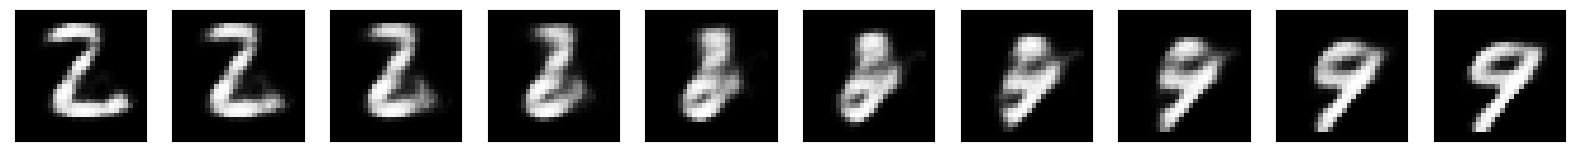

In [14]:
# linear interpolation

data, _ = next(iter(test_loader))
data = data.view([-1, 784])
data.requires_grad = False
data = data.to(device)

encoded_imgs = model.encoder(data)

encoded_imag_2 = encoded_imgs[1]
encoded_imag_9 = encoded_imgs[9]

    
n = 10
plt.figure(figsize=(20, 4))
for i in range(n):
    # display reconstruction
    ax = plt.subplot(1, n, i + 1)
    
    eta = i/n;
    encoded_imgs_interp = (1-eta) * encoded_imag_2 + eta * encoded_imag_9
    plt.imshow( to_img( model.decoder( encoded_imgs_interp ) )[0] )
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    
plt.show()  

In [15]:
# denoising with autoencoder

def train_denoiser(model,loss_fn,data_loader=None,epochs=1,optimizer=None, noise=0.1):
    model.train()
    for epoch in range(epochs):
        for batch_idx, (data, _) in enumerate(train_loader):
            data = data.view([-1, 784]).to(device)
            noisy_data = data + noise * torch.randn(*data.shape)
            optimizer.zero_grad()
            output = model(noisy_data)
            loss = loss_fn(output, data)
            loss.backward()
            optimizer.step()
            
            if batch_idx % 100 == 0:
                print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                    epoch, batch_idx * len(data), len(data_loader.dataset),
                    100. * batch_idx / len(data_loader), loss.data.item()))

In [16]:
input_dim = 784
encoding_dim = 32

model = DeepAutoEncoder(input_dim, encoding_dim)
model = model.to(device)
optimizer = optim.Adam(model.parameters())
# loss_fn = torch.nn.BCEWithLogitsLoss()
loss_fn = torch.nn.MSELoss()

In [17]:
train_denoiser(model, loss_fn, data_loader=train_loader, epochs=10, optimizer=optimizer, noise=0.8)

Train Epoch: 0 [0/60000 (0%)]	Loss: 0.231882
Train Epoch: 0 [25600/60000 (43%)]	Loss: 0.066594
Train Epoch: 0 [51200/60000 (85%)]	Loss: 0.056934
Train Epoch: 1 [0/60000 (0%)]	Loss: 0.052505
Train Epoch: 1 [25600/60000 (43%)]	Loss: 0.043374
Train Epoch: 1 [51200/60000 (85%)]	Loss: 0.040800
Train Epoch: 2 [0/60000 (0%)]	Loss: 0.038645
Train Epoch: 2 [25600/60000 (43%)]	Loss: 0.038944
Train Epoch: 2 [51200/60000 (85%)]	Loss: 0.037626
Train Epoch: 3 [0/60000 (0%)]	Loss: 0.036794
Train Epoch: 3 [25600/60000 (43%)]	Loss: 0.034923
Train Epoch: 3 [51200/60000 (85%)]	Loss: 0.034785
Train Epoch: 4 [0/60000 (0%)]	Loss: 0.034935
Train Epoch: 4 [25600/60000 (43%)]	Loss: 0.033611
Train Epoch: 4 [51200/60000 (85%)]	Loss: 0.031267
Train Epoch: 5 [0/60000 (0%)]	Loss: 0.032449
Train Epoch: 5 [25600/60000 (43%)]	Loss: 0.033588
Train Epoch: 5 [51200/60000 (85%)]	Loss: 0.031492
Train Epoch: 6 [0/60000 (0%)]	Loss: 0.030279
Train Epoch: 6 [25600/60000 (43%)]	Loss: 0.031418
Train Epoch: 6 [51200/60000 (85%)]	

In [18]:
def plot_denoising(model, noise=0.1):
    """
    Plot 10 reconstructions from the test set. The top row is the original
    digits, , the second row is the noisy digits, 
    the third row is the encoded vector and
    the bottom is the decoder reconstruction.
    """
    # encode then decode
    data, _ = next(iter(test_loader))
    
    data = data.view([-1, 784]).to(device)
    data.requires_grad = False
    noisy_data = data + noise * torch.randn(*data.shape)

    encoded_imgs = model.encoder(data)
    decoded_imgs = model.decoder(encoded_imgs)

    true_imgs = to_img(data)
    noisy_imgs = to_img(noisy_data)
    decoded_imgs = to_img(decoded_imgs)
    encoded_imgs = encoded_imgs.cpu().data.numpy()
    
    n = 10
    plt.figure(figsize=(20, 4))
    for i in range(n):
        # display original
        ax = plt.subplot(4, n, i + 1)
        plt.imshow(true_imgs[i])
        plt.gray()
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)
        
        # display corrupted original
        ax = plt.subplot(4, n, i + 1 +n)
        plt.imshow(noisy_imgs[i])
        plt.gray()
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)
        
        # display code
        ax = plt.subplot(4, n, i + 1 + 2*n)
        plt.imshow(encoded_imgs[i].reshape(-1,4))
        plt.gray()
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)

        # display reconstruction
        ax = plt.subplot(4, n, i + 1 +  3*n)
        plt.imshow(decoded_imgs[i])
        plt.gray()
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)
    
    plt.show()    

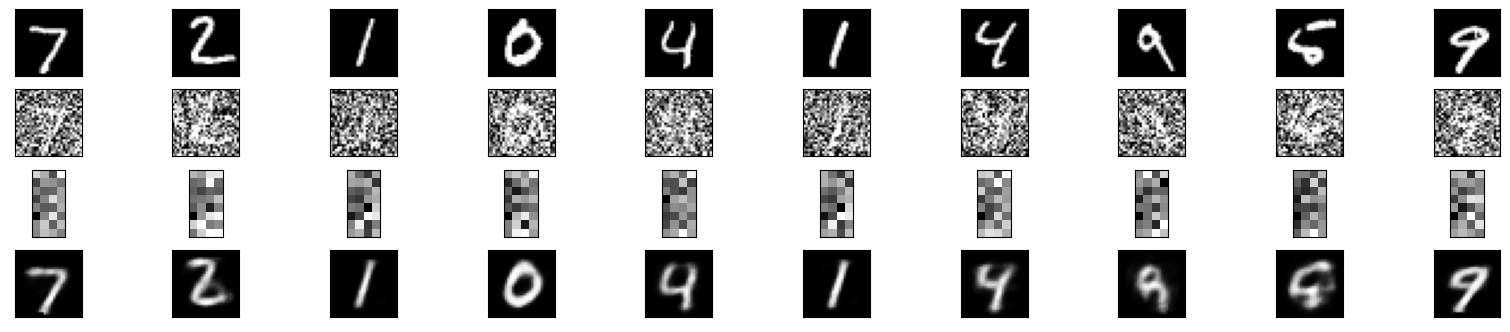

In [19]:
plot_denoising(model, noise=0.8)